In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV

from sklearn.externals import joblib

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
train=pd.read_csv('E:\\restaurant_train.csv',encoding='latin1')
test=pd.read_csv('E:\\restaurant_test.csv',encoding='latin1')

In [3]:
#combining both train and test data sets into one to perform feature engineering and then divide them later again. 
#This saves the trouble of performing the same steps twice on test and train. 

df= pd.concat([train, test],ignore_index=True)#axis=0(default)rowwise
print (train.shape, test.shape, df.shape)

(12690, 9) (4231, 8) (16921, 9)


In [4]:
df.head()

,CITY,COST,CUISINES,LOCALITY,RATING,RESTAURANT_ID,TIME,TITLE,VOTES
0,Thane,1200.0,"Malwani, Goan, North Indian",Dombivali East,3.6,9438,"11am  4pm, 7:30pm  11:30pm (Mon-Sun)",CASUAL DINING,49 votes
1,Chennai,1500.0,"Asian, Modern Indian, Japanese",Ramapuram,4.2,13198,6pm  11pm (Mon-Sun),"CASUAL DINING,BAR",30 votes
2,Chennai,800.0,"North Indian, Chinese, Biryani, Hyderabadi",Saligramam,3.8,10915,"11am  3:30pm, 7pm  11pm (Mon-Sun)",CASUAL DINING,221 votes
3,Mumbai,800.0,"Tibetan, Chinese",Bandra West,4.1,6346,11:30am  1am (Mon-Sun),QUICK BITES,24 votes
4,Mumbai,300.0,Desserts,Lower Parel,3.8,15387,11am  1am (Mon-Sun),DESSERT PARLOR,165 votes


In [5]:
#Price is the target variable and all values are missing as they are from test set. 
#we’ll impute all the missing values(if present) except the Price column.
df.tail()

,CITY,COST,CUISINES,LOCALITY,RATING,RESTAURANT_ID,TIME,TITLE,VOTES
16916,New Delhi,NaN,"North Indian, Mughlai, Chinese",Punjabi Bagh,3.9,9057,11:30am  11:30pm (Mon-Sun),CASUAL DINING,287 votes
16917,Bangalore,NaN,"Biryani, North Indian, Sandwich, Salad, Wraps",HSR Layout,4.3,1247,11am  1am (Mon-Sun),None,469 votes
16918,Faridabad,NaN,"Continental, North Indian",Sector 86,3.7,8617,9:30am  10:30pm (Mon-Sun),QUICK BITES,53 votes
16919,Kochi,NaN,"Rolls, Beverages",Kochi,-,6485,"11am  11:30pm (Mon, Tue, Wed, Thu, Sat, Sun),...",QUICK BITES,NaN
16920,Bandra West,NaN,Mughlai,Perry Cross Road,3.7,2421,5pm  1am (Mon-Sun),QUICK BITES,63 votes


In [6]:
df.shape

(16921, 9)

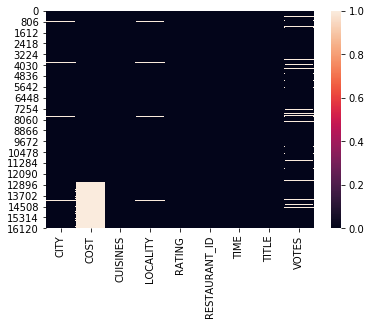

In [7]:
sns.heatmap(df.isnull())

In [12]:
df.isnull().sum()#there are more missing values in '-' form.which is not detected by the system as missing values.
                #there are rows in rating column as 'NEW',we will treat them as missing values. 

CITY              147
COST             4231
CUISINES            0
LOCALITY          128
RATING           1606
RESTAURANT_ID       0
TIME                0
TITLE               0
VOTES            1606
dtype: int64

# Feature Engineering

# Coverting '_ ' to NAN

In [13]:
df=df.replace('-',np.nan)

# Coverting 'NEW' to NAN

In [14]:
df=df.replace('NEW',np.nan)

In [15]:
df.isnull().sum()#we can see the number of missing value have increased.

CITY              147
COST             4231
CUISINES            0
LOCALITY          128
RATING           1606
RESTAURANT_ID       0
TIME                0
TITLE               0
VOTES            1606
dtype: int64

# Checking the number of categories in each categorical column

In [16]:
categorical_features=[feature for feature in df.columns if df[feature].dtypes=='object']
for feature in categorical_features:
    if df[feature].nunique()>=1:
        print(feature,df[feature].nunique())

CITY 450
CUISINES 5183
LOCALITY 1636
RATING 30
TIME 3295
TITLE 123
VOTES 2075


In [17]:
df.dtypes

CITY              object
COST             float64
CUISINES          object
LOCALITY          object
RATING            object
RESTAURANT_ID      int64
TIME              object
TITLE             object
VOTES             object
dtype: object

In [18]:
df.describe()
#we can see for item_visibility the minimum value is 0.which is practically not possible.
#lets consider the value 0 as an missing value and impute it with the mean of the column.

,COST,RESTAURANT_ID
count,12690.000000,16921.000000
mean,655.252246,7767.211631
std,627.003540,4493.287626
min,20.000000,0.000000
25%,300.000000,3873.000000
50%,500.000000,7751.000000
75%,800.000000,11672.000000
max,14000.000000,15573.000000


# imputing missing values

In [19]:
df.isnull().sum()

CITY              147
COST             4231
CUISINES            0
LOCALITY          128
RATING           1606
RESTAURANT_ID       0
TIME                0
TITLE               0
VOTES            1606
dtype: int64

# Changing dtype of RATING column

In [20]:
df['RATING']=df['RATING'].apply(pd.to_numeric)

In [21]:
df.dtypes

CITY              object
COST             float64
CUISINES          object
LOCALITY          object
RATING           float64
RESTAURANT_ID      int64
TIME              object
TITLE             object
VOTES             object
dtype: object

In [22]:
#Imputing missing values except the target column(cost)

df['RATING']=df['RATING'].fillna(df['RATING'].mean())
df['VOTES']=df['VOTES'].fillna(df['VOTES'].mode()[0])
df['LOCALITY']=df['LOCALITY'].fillna(df['LOCALITY'].mode()[0])
df['CITY']=df['CITY'].fillna(df['CITY'].mode()[0])

# creating a new column and segregating the items

In [23]:

df['VOTES_new'] = df['VOTES'].apply(lambda x:x[:-5])


In [24]:
df['VOTES_new']=df['VOTES_new'].apply(pd.to_numeric)

In [25]:
df.isnull().sum()

CITY                0
COST             4231
CUISINES            0
LOCALITY            0
RATING              0
RESTAURANT_ID       0
TIME                0
TITLE               0
VOTES               0
VOTES_new           0
dtype: int64

In [26]:
df.dtypes

CITY              object
COST             float64
CUISINES          object
LOCALITY          object
RATING           float64
RESTAURANT_ID      int64
TIME              object
TITLE             object
VOTES             object
VOTES_new          int64
dtype: object

# Dropping VOTES column as we have extracted features we want from it

In [27]:
df=df.drop('VOTES',axis=1)

In [28]:
#we dont have to worry about the missing values in Item_Outlet_Sales
df.isnull().sum()

CITY                0
COST             4231
CUISINES            0
LOCALITY            0
RATING              0
RESTAURANT_ID       0
TIME                0
TITLE               0
VOTES_new           0
dtype: int64

# EDA

# Univariate Analysis

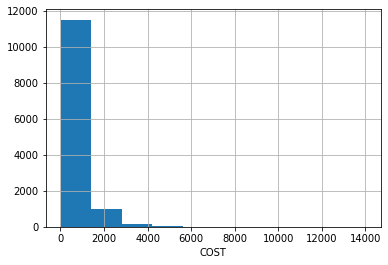

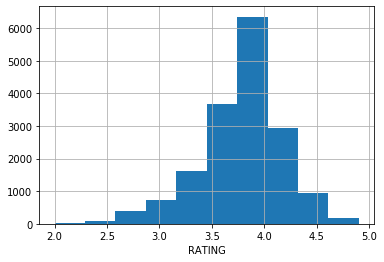

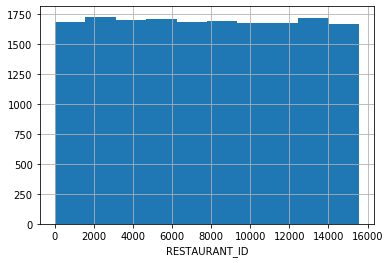

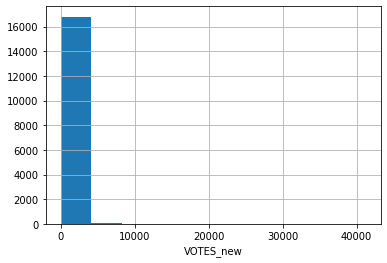

In [29]:
#checking skewness
numerical_features=[feature for feature in df.columns if df[feature].dtypes!='object']
for feature in numerical_features:
    
    df[feature].hist()
    plt.xlabel(feature)
    plt.show()

In [30]:
#We can see few data are right skewed,which are to be treated

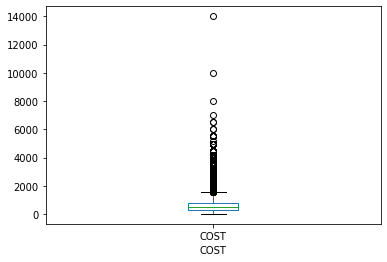

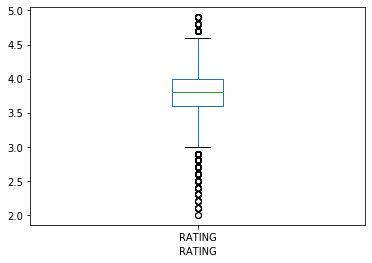

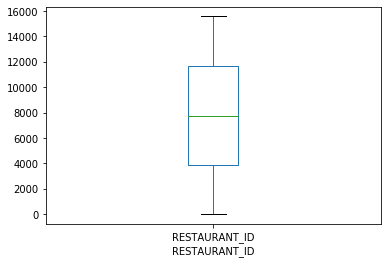

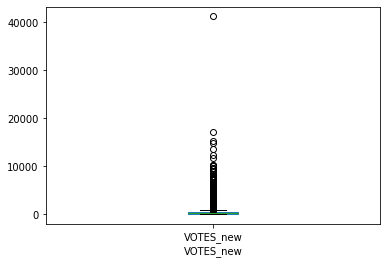

In [31]:
#checking outliers
numerical_features=[feature for feature in df.columns if df[feature].dtypes!='object']
for feature in numerical_features:
    
    df[feature].plot.box()
    plt.xlabel(feature)
    plt.show()

In [32]:
df.head()

,CITY,COST,CUISINES,LOCALITY,RATING,RESTAURANT_ID,TIME,TITLE,VOTES_new
0,Thane,1200.0,"Malwani, Goan, North Indian",Dombivali East,3.6,9438,"11am  4pm, 7:30pm  11:30pm (Mon-Sun)",CASUAL DINING,49
1,Chennai,1500.0,"Asian, Modern Indian, Japanese",Ramapuram,4.2,13198,6pm  11pm (Mon-Sun),"CASUAL DINING,BAR",30
2,Chennai,800.0,"North Indian, Chinese, Biryani, Hyderabadi",Saligramam,3.8,10915,"11am  3:30pm, 7pm  11pm (Mon-Sun)",CASUAL DINING,221
3,Mumbai,800.0,"Tibetan, Chinese",Bandra West,4.1,6346,11:30am  1am (Mon-Sun),QUICK BITES,24
4,Mumbai,300.0,Desserts,Lower Parel,3.8,15387,11am  1am (Mon-Sun),DESSERT PARLOR,165


In [33]:
df.tail()

,CITY,COST,CUISINES,LOCALITY,RATING,RESTAURANT_ID,TIME,TITLE,VOTES_new
16916,New Delhi,NaN,"North Indian, Mughlai, Chinese",Punjabi Bagh,3.900000,9057,11:30am  11:30pm (Mon-Sun),CASUAL DINING,287
16917,Bangalore,NaN,"Biryani, North Indian, Sandwich, Salad, Wraps",HSR Layout,4.300000,1247,11am  1am (Mon-Sun),None,469
16918,Faridabad,NaN,"Continental, North Indian",Sector 86,3.700000,8617,9:30am  10:30pm (Mon-Sun),QUICK BITES,53
16919,Kochi,NaN,"Rolls, Beverages",Kochi,3.784473,6485,"11am  11:30pm (Mon, Tue, Wed, Thu, Sat, Sun),...",QUICK BITES,44
16920,Bandra West,NaN,Mughlai,Perry Cross Road,3.700000,2421,5pm  1am (Mon-Sun),QUICK BITES,63


# Feature Engineering part-2

In [34]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df['CITY']=le.fit_transform(df['CITY'])

In [35]:
df['CUISINES']=le.fit_transform(df['CUISINES'])

In [36]:
df['LOCALITY']=le.fit_transform(df['LOCALITY'])

In [37]:
df['TITLE']=le.fit_transform(df['TITLE'])

In [38]:
df=df.drop(['RESTAURANT_ID','TIME'],axis=1)

# Removing Skewness

In [39]:
df.skew()

CITY          0.254523
COST          3.978801
CUISINES     -0.229200
LOCALITY      0.370844
RATING       -0.553966
TITLE        -0.061023
VOTES_new    12.780223
dtype: float64

In [40]:
y=df['COST']

In [41]:
df=df.drop('COST',axis=1)

In [42]:
from sklearn.preprocessing import PowerTransformer
pt=PowerTransformer(method='yeo-johnson') 
df_power=pt.fit_transform(df)
df=pd.DataFrame(df_power,columns=df.columns)

In [43]:
df.skew()

CITY        -0.143213
CUISINES    -0.358482
LOCALITY    -0.129502
RATING       0.028809
TITLE       -0.252697
VOTES_new    0.011688
dtype: float64

In [44]:
df.head()

,CITY,CUISINES,LOCALITY,RATING,TITLE,VOTES_new
0,1.690011,0.362905,-0.878251,-0.530523,-0.800892,-0.745594
1,-0.885849,-1.698769,0.999975,1.064819,-0.737437,-1.112073
2,-0.885849,0.631839,1.092369,-0.037527,-0.800892,0.340933
3,0.960008,1.482325,-1.485893,0.774291,1.051284,-1.279952
4,0.960008,-0.329127,0.077425,-0.037527,-0.177633,0.135549


In [45]:
df.tail()

,CITY,CUISINES,LOCALITY,RATING,TITLE,VOTES_new
16916,1.208852,0.952884,0.951319,0.223276,-0.800892,0.522243
16917,-1.429164,-1.350474,-0.501304,1.365570,0.841376,0.856890
16918,-0.250998,-0.415305,1.243827,-0.288740,1.051284,-0.687431
16919,0.526080,1.144212,-0.067317,-0.077159,1.051284,-0.825593
16920,-1.469006,0.485355,0.892113,-0.288740,1.051284,-0.559846


In [46]:
df.shape

(16921, 6)

In [47]:
df=pd.concat([df,y],axis=1)

# separating training and testing datasets

In [48]:
train=df[0:12690]
test=df[12690:]

In [49]:
train.tail()

,CITY,CUISINES,LOCALITY,RATING,TITLE,VOTES_new,COST
12685,0.059558,0.599350,-0.680406,-0.037527,1.051284,0.958852,500.0
12686,0.960008,-0.024064,-1.499189,1.365570,-0.737437,1.482264,1800.0
12687,1.109046,-0.067372,1.505683,0.493830,0.452886,1.030531,1300.0
12688,-0.885849,1.037197,0.100525,-0.763035,-0.800892,-1.063628,400.0
12689,0.059558,0.607939,1.492817,-0.986439,-0.800892,1.101788,600.0


In [50]:
test.head()

,CITY,CUISINES,LOCALITY,RATING,TITLE,VOTES_new,COST
12690,1.251594,0.722786,1.157968,1.365570,-0.800892,0.980509,NaN
12691,0.960008,1.320517,-0.586422,1.064819,1.051284,-0.583603,NaN
12692,0.960008,0.997188,0.211455,-0.037527,-0.800892,0.658429,NaN
12693,-0.250998,-1.473246,0.353515,-0.037527,0.841376,1.593591,NaN
12694,0.526080,1.327557,-0.231540,-0.530523,1.051284,-1.312021,NaN


In [51]:
#Dropping target column(cost)as it contains all NAN values.
test=test.drop(['COST'],axis=1)

In [52]:
train.head()

,CITY,CUISINES,LOCALITY,RATING,TITLE,VOTES_new,COST
0,1.690011,0.362905,-0.878251,-0.530523,-0.800892,-0.745594,1200.0
1,-0.885849,-1.698769,0.999975,1.064819,-0.737437,-1.112073,1500.0
2,-0.885849,0.631839,1.092369,-0.037527,-0.800892,0.340933,800.0
3,0.960008,1.482325,-1.485893,0.774291,1.051284,-1.279952,800.0
4,0.960008,-0.329127,0.077425,-0.037527,-0.177633,0.135549,300.0


In [53]:
test.head()

,CITY,CUISINES,LOCALITY,RATING,TITLE,VOTES_new
12690,1.251594,0.722786,1.157968,1.365570,-0.800892,0.980509
12691,0.960008,1.320517,-0.586422,1.064819,1.051284,-0.583603
12692,0.960008,0.997188,0.211455,-0.037527,-0.800892,0.658429
12693,-0.250998,-1.473246,0.353515,-0.037527,0.841376,1.593591
12694,0.526080,1.327557,-0.231540,-0.530523,1.051284,-1.312021


In [54]:
train.shape,test.shape

((12690, 7), (4231, 6))

# Data Scaling 

In [55]:
#Applying Standard scalar to independent variable only of training dataset
train_features_toscale=[feature for feature in train.columns if feature not in ['COST'] ]

from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
train_scaled=ss.fit_transform(train[train_features_toscale])
train_scaled=pd.DataFrame(data=train_scaled,columns=train[train_features_toscale].columns)


In [56]:
train_scaled.head()

,CITY,CUISINES,LOCALITY,RATING,TITLE,VOTES_new
0,1.686626,0.362590,-0.879914,-0.534452,-0.802723,-0.745739
1,-0.877668,-1.691358,0.997965,1.068852,-0.739269,-1.113713
2,-0.877668,0.630516,1.090343,-0.038996,-0.802723,0.345219
3,0.959901,1.477815,-1.487444,0.776874,1.049437,-1.282277
4,0.959901,-0.326848,0.075586,-0.038996,-0.179469,0.138997


In [57]:
train=pd.concat([train['COST'],train_scaled],axis=1)

In [58]:
train.head()

,COST,CITY,CUISINES,LOCALITY,RATING,TITLE,VOTES_new
0,1200.0,1.686626,0.362590,-0.879914,-0.534452,-0.802723,-0.745739
1,1500.0,-0.877668,-1.691358,0.997965,1.068852,-0.739269,-1.113713
2,800.0,-0.877668,0.630516,1.090343,-0.038996,-0.802723,0.345219
3,800.0,0.959901,1.477815,-1.487444,0.776874,1.049437,-1.282277
4,300.0,0.959901,-0.326848,0.075586,-0.038996,-0.179469,0.138997


In [59]:
#Applying Standard scalar to test dataset
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
test_scaled=ss.fit_transform(test)
test=pd.DataFrame(data=test_scaled,columns=test.columns)


In [60]:
test.head()

,CITY,CUISINES,LOCALITY,RATING,TITLE,VOTES_new
0,1.256216,0.727921,1.164111,1.349503,-0.795416,0.960302
1,0.960561,1.332529,-0.581281,1.053120,1.056847,-0.585208
2,0.960561,1.005479,0.217054,-0.033213,-0.795416,0.642053
3,-0.267342,-1.493377,0.359196,-0.033213,0.846929,1.566094
4,0.520579,1.339649,-0.226196,-0.519048,1.056847,-1.304964


# Model Building

In [61]:
y=train['COST']
x=train.drop(['COST'],axis=1)

In [62]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor

In [63]:
knn=KNeighborsRegressor()
svr=SVR()
lr=LinearRegression()
dt=DecisionTreeRegressor()
gbm=GradientBoostingRegressor()
ada=AdaBoostRegressor()
rfr=RandomForestRegressor()
xgb=XGBRegressor()

In [64]:
models=[]
models.append(('KNeighborsClassifier',knn))
models.append(('SVR',svr))
models.append(('LinearRegression',lr))
models.append(('DecisionTreeRegressor',dt))
models.append(('GradientBoostingRegressor',gbm))
models.append(('AdaBoostRegressor',ada))
models.append(('RandomForestRegressor',rfr))
models.append(('XGBRegressor',xgb))

In [65]:
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split,cross_val_score
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42)

In [81]:
Model=[]
r2score=[]
rmse=[]
cv=[]

for name,model in models:
    print('*****************',name,'*******************')
    print('\n')
    Model.append(name)
    model.fit(x_train,y_train)
    print(model)
    pre=model.predict(x_test)
    print('\n')
    score=r2_score(y_test,pre)
    print('R2score  -',score)
    r2score.append(score*100)
    print('\n')
    sc=cross_val_score(model,x,y,cv=5,scoring='r2').mean()
    print('cross_val_score  -',sc)
    cv.append(sc*100)
    print('\n')
    rmsescore=mean_squared_error(y_test,pre)
    print('rmse_score  -',np.sqrt(rmsescore))
    rmse.append(np.sqrt(rmsescore))
    print('\n')
    
    
    

***************** KNeighborsClassifier *******************


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')


R2score  - 0.3473305354563452


cross_val_score  - 0.38525972026239


rmse_score  - 480.3702391449343


***************** SVR *******************


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)


R2score  - 0.11348288884888047


cross_val_score  - 0.10818385592751831


rmse_score  - 559.8517077811906


***************** LinearRegression *******************


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


R2score  - 0.18770871872719308


cross_val_score  - 0.18827495449978485


rmse_score  - 535.9019556697015


***************** DecisionTreeRegressor *******************


DecisionTreeRegressor(c

In [82]:
result=pd.DataFrame({'Model':Model,'R2_score':r2score,'RMSEscore':rmse,'Cross_val_score':cv})
result

,Model,R2_score,RMSEscore,Cross_val_score
0,KNeighborsClassifier,34.733054,480.370239,38.525972
1,SVR,11.348289,559.851708,10.818386
2,LinearRegression,18.770872,535.901956,18.827495
3,DecisionTreeRegressor,49.106115,424.191780,47.784779
4,GradientBoostingRegressor,72.152745,313.776665,69.389903
5,AdaBoostRegressor,-48.512735,724.621632,-36.324934
6,RandomForestRegressor,70.928862,320.597743,68.342354
7,XGBRegressor,75.903660,291.880438,71.812201


In [ ]:
#We can see XGBRegressor is performing the best as difference between the score and cross_val_score is the minimum.
#And also the RMSE score is well within range for this particular problem.

In [ ]:
#But our target score is 90%
#Hence we will apply Gridsearchcv to the top3 performing model and try to reach 90% score.

In [ ]:
#First lets calculate the random state of the models at which they perform the best.
#Then we will select the top3 models and do gridsearchcv on them to attain our target score of 90%.
#Then Cross validating the model and checking the cross_val_score,model giving highest score will be choosen as final model.

# Finding the best random_state for GradientBoostingRegressor

In [91]:
def maxr2_score(model,x,y):
    max_r2=0
    for r_state in range(42,101):
        
        x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=r_state)
        model.fit(x_train,y_train)
        pred=model.predict(x_test)
        score=r2_score(y_test,pred)
        
        if score>max_r2:
            max_r2=score
            final_r_state=r_state
    print('max_r2_score is at random_state  ',final_r_state,'  which is  ',max_r2)
    return final_r_state

In [92]:
print('knn',maxr2_score(knn,x,y))
print('SVR',maxr2_score(svr,x,y))
print('lr',maxr2_score(lr,x,y))
print('dt',maxr2_score(dt,x,y))
print('gbm',maxr2_score(gbm,x,y))
print('rfr',maxr2_score(rfr,x,y))
print('xgb',maxr2_score(xgb,x,y))



max_r2_score is at random_state   43   which is   0.4645321840799389
knn 43
max_r2_score is at random_state   79   which is   0.13428376863617342
SVR 79
max_r2_score is at random_state   67   which is   0.22294427055442678
lr 67
max_r2_score is at random_state   93   which is   0.585218096987401
dt 93
max_r2_score is at random_state   77   which is   0.739123410958528
gbm 77
max_r2_score is at random_state   93   which is   0.7298289738769949
rfr 93
max_r2_score is at random_state   42   which is   0.7590365976350736
xgb 42


# GridSearchCV

# model1->XGBoostRegressor(random_state=42)=75.9

In [66]:
from sklearn.model_selection import GridSearchCV
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42)
xgb=XGBRegressor()

In [67]:
parameters=[{'learning_rate':[0.1,0.2,0.3,0.4,0.45,0.46,0.44,0.5],'max_depth':[3,4,5,6,7,8,9,10],'colsample_bytree':[0.3,0.4,0.5,0.6,0.7,0.8,0.9]}]
            
gscv=GridSearchCV(xgb,parameters,scoring='r2',n_jobs=-1,cv=5)
grid_search=gscv.fit(x,y)
grid_search.best_params_

{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 8}

In [80]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42)
xgb=XGBRegressor(colsample_bytree=0.5, learning_rate=0.1, max_depth=8)
xgb.fit(x,y)
pred=xgb.predict(x_test)
print('r2_score=  ',r2_score(y_test,pred))
print('RMSE score= ',np.sqrt(mean_squared_error(y_test,pred)))

r2_score=   0.9080012132410549
RMSE score=  180.35180620249255


In [81]:
#Cross validating the model and checking the cross_val_score,model giving highest score will be choosen as final model.
xgb=XGBRegressor(colsample_bytree=0.5, learning_rate=0.1, max_depth=8)
xgb.fit(x,y)
cvs=cross_val_score(xgb,x,y,scoring='r2',cv=5)
print('cross_val_scores=  ',cvs.mean())

cross_val_scores=   0.7405109434788917


# model2->GradientBoostingRegressor(random_state=51)=73.91

In [70]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=51)
gbm=GradientBoostingRegressor()

In [71]:
parameters=[{'max_depth':[5,7,9,10],'min_samples_leaf':[1,2],'n_estimators':[100,250,500]}]
            
grid_search=GridSearchCV(gbm,parameters,scoring='r2',n_jobs=-1,cv=5)
grid_search=grid_search.fit(x,y)
grid_search.best_params_ 

{'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 250}

In [82]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=94)
gbm=GradientBoostingRegressor(max_depth=5,min_samples_leaf=2,n_estimators=250)
gbm.fit(x,y)
pred_gbm=gbm.predict(x_test)
score=r2_score(y_test,pred_gbm)
print('R2_score=  ',score)
print('RMSE score= ',np.sqrt(mean_squared_error(y_test,pred_gbm)))

R2_score=   0.8675675130059961
RMSE score=  214.8798787417614


In [83]:
#Cross validating the model and checking the cross_val_score,model giving highest score will be choosen as final model.
gbm=GradientBoostingRegressor(max_depth=5,min_samples_leaf=2,n_estimators=250)
gbm.fit(x,y)
cvs=cross_val_score(gbm,x,y,scoring='r2',cv=5)
print('cross_val_scores=  ',cvs.mean())

cross_val_scores=   0.7329797860613827


# model3->RandomForestRegressor(random_state=49)=72.98

In [76]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=49)
rfr=RandomForestRegressor()

In [77]:
parameters=[{'max_depth':[5,7,9,10],'min_samples_leaf':[1,2],'n_estimators':[100,250,500]}]
            
grid_search=GridSearchCV(rfr,parameters,scoring='r2',n_jobs=-1,cv=5)
grid_search=grid_search.fit(x,y)
grid_search.best_params_ 

{'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 500}

In [84]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=49)
rfr=RandomForestRegressor(max_depth=10,min_samples_leaf=2,n_estimators=500)
rfr.fit(x,y)
pred_rfr=rfr.predict(x_test)
score=r2_score(y_test,pred_rfr)
print('R2_score=  ',score)
print('RMSE score= ',np.sqrt(mean_squared_error(y_test,pred_rfr)))

R2_score=   0.7847559133120772
RMSE score=  295.1124798869804


In [85]:
#Cross validating the model and checking the cross_val_score,model giving highest score will be choosen as final model.
rfr=RandomForestRegressor(max_depth=10,min_samples_leaf=2,n_estimators=500)
rfr.fit(x,y)
cvs=cross_val_score(rfr,x,y,scoring='r2',cv=5)
print('cross_val_scores=  ',cvs.mean())

cross_val_scores=   0.7104041781469919


# Saving final XGBoostRegressor model

In [86]:
#From all the model tried above XGBoostRegressor model has highest cross_val_score=74.05% .
#Hence saving the XGBoostRegressor model as our final model
#corresponding random_state=94
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42)
xgb=XGBRegressor(colsample_bytree=0.5, learning_rate=0.1, max_depth=8)
xgb.fit(x,y)
pred=xgb.predict(x_test)
print('r2_score=  ',r2_score(y_test,pred))
print('RMSE score= ',np.sqrt(mean_squared_error(y_test,pred)))

r2_score=   0.9080012132410549
RMSE score=  180.35180620249255


In [87]:
xgb=XGBRegressor(colsample_bytree=0.5, learning_rate=0.1, max_depth=8)
xgb.fit(x,y)
cvs=cross_val_score(xgb,x,y,scoring='r2',cv=5)
print('cross_val_scores=  ',cvs.mean())

cross_val_scores=   0.7405109434788917


In [88]:
from sklearn.externals import joblib
joblib.dump(xgb,'practiceproject_18.obj')

['practiceproject_18.obj']

In [89]:
model=joblib.load('practiceproject_18.obj')

In [90]:
test=model.predict(x_test)
test

array([ 464.4476,  529.128 ,  626.6627, ..., 1152.232 ,  583.8267,
       1230.4155], dtype=float32)

# Saving final predictions in file.csv

In [91]:
final_predictions=pd.DataFrame(test,columns=['COST'])

In [92]:
final_predictions.to_csv('E:\\final_predictionsrestaurantcost.csv',index=False)